In [1]:
from keras import backend as K
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
#load training data
train = json.load(open('../data/train.json'))

In [4]:
#load test data
test = json.load(open('../data/test.json'))

## Pre-Processs

In [5]:
def normalize(X1):
    '''normalizes to 0 to 1 scale'''
    norm = ((X1-X1.min())/(X1.max()-X1.min()))
    return norm

def preprocess(data):
    '''
    preprocesses the data and returns two list of processed data, 
    one normalized on 0 to 1 scale, dual channel picture, 75x75x2
    one normalized to power ratio, and combined, single channel picture, 75x75x1
    '''
    #make empty list for dataset normalized from 0 to 1
    X_data_scale = list()

    #make empty list for dataset normalized by power ratio
    X_data_power = list()

    #itterate over each element of the data
    for i in range(len(data)):
        #get elements of entry
        id = (data[i]['id'])
        B1 = np.reshape(data[i]['band_1'], (75,75))
        B2 = np.reshape(data[i]['band_2'], (75,75))
        
        #normalize to 0 to 1 range
        B1_norm = normalize(B1)
        B11_norm = normalize(B1)
        B2_norm = normalize(B2)
        norm_merge = np.dstack((B1_norm, B11_norm, B2_norm))
        
        #transform to power
        B1_power = np.power(10, np.divide(B1, 20))
        B2_power = np.power(10, np.divide(B2, 20))
        #power_merge = normalize(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_power,10)),np.power(10,np.divide(B2_power,10))))))
        power_merge = np.dstack((B1_power,B2_power))

        #df.append({'id':id, 'image':norm_merge})
        #dp.append({'id':id, 'image':power_merge})
        X_data_scale.append(norm_merge)
        X_data_power.append(power_merge)
        
    return np.array(X_data_scale), np.array(X_data_power)

def get_classification(data):
    '''retrieves classification for each image in testing dataset'''
    y_data = list()
    for i in range(len(data)):
        #id = (data[i]['id'])
        classification = (data[i]['is_iceberg'])
        #target.append({'id':id, 'is_iceberg':classification})
        y_data.append([classification])
    return(np.array(y_data))

def get_id(data):
    '''retrieves classification for each image in testing dataset'''
    id = list()
    for i in range(len(data)):
        sample = (data[i]['id'])
        id.append([sample])
    return(np.array(id))

def get_angle(data):
    '''retrieves classification for each image in testing dataset'''
    angle = list()
    for i in range(len(data)):
        sample = (data[i]['inc_angle'])
        angle.append(sample)
    return(angle)

In [6]:
#preprocess training dataset
X_train_scale, X_train_power = preprocess(train)
y_train = get_classification(train)
train_id = get_id(train)

In [7]:
#preprocess testing dataset
X_test_scale, X_test_power = preprocess(test)
test_id = get_id(test)

## Test Train Split

In [8]:
#split training & testing set
from sklearn.model_selection import train_test_split
X_train_d_scale, X_test_d_scale, y_train_d_scale, y_test_d_scale = train_test_split(X_train_scale, y_train, test_size=0.2, random_state=0)

# Model

In [9]:
#hyperparameters
batch_size = 16 #number of training examples to consider at once
num_epochs = 100 #itterate n times over training set
kernal_size = 3 #3x3 kernal
pool_size = 2 #2x2 pooling
conv_depth_1 = 32 # first layer 32 kernals
conv_depth_2 = 32 # first layer 32 kernals
conv_depth_3 = 64 # second layer 64 kernals
dense_1 = 64
dense_2 = 1
drop_out = 0.5 #drop out probability
hidden_size = 512 #number of neurons in fully-connected layer

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(conv_depth_1, (kernal_size, kernal_size), input_shape=(75,75,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Conv2D(conv_depth_2, (kernal_size, kernal_size)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Conv2D(conv_depth_3, (kernal_size, kernal_size)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(dense_1))
model.add(Activation('relu'))
model.add(Dropout(drop_out))
model.add(Dense(dense_2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [11]:
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [12]:
train_generator = train_datagen.flow(
        X_train_d_scale, y_train_d_scale,  # this is the target directory
        batch_size=batch_size)

In [13]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=num_epochs,
        validation_data=(X_test_d_scale,y_test_d_scale),
        validation_steps=800 // batch_size)

Epoch 1/100
125/125 [==============================] - 39s 312ms/step - loss: 0.6797 - acc: 0.5962 - val_loss: 0.6443 - val_acc: 0.6791
Epoch 2/100
125/125 [==============================] - 31s 244ms/step - loss: 0.6015 - acc: 0.6642 - val_loss: 0.5760 - val_acc: 0.7259
Epoch 3/100
125/125 [==============================] - 30s 241ms/step - loss: 0.5322 - acc: 0.7248 - val_loss: 0.4841 - val_acc: 0.7726
Epoch 4/100
125/125 [==============================] - 30s 237ms/step - loss: 0.4896 - acc: 0.7718 - val_loss: 0.5406 - val_acc: 0.7632
Epoch 5/100
125/125 [==============================] - 27s 213ms/step - loss: 0.4622 - acc: 0.7813 - val_loss: 0.4121 - val_acc: 0.8255
Epoch 6/100
125/125 [==============================] - 27s 215ms/step - loss: 0.4488 - acc: 0.8133 - val_loss: 0.4279 - val_acc: 0.8255
Epoch 7/100
125/125 [==============================] - 28s 226ms/step - loss: 0.4258 - acc: 0.8075 - val_loss: 0.4958 - val_acc: 0.7508
Epoch 8/100
125/125 [===========================

Epoch 61/100
125/125 [==============================] - 19s 151ms/step - loss: 0.1969 - acc: 0.9305 - val_loss: 0.4046 - val_acc: 0.8754
Epoch 62/100
125/125 [==============================] - 20s 157ms/step - loss: 0.2117 - acc: 0.9155 - val_loss: 0.3441 - val_acc: 0.8816
Epoch 63/100
125/125 [==============================] - 19s 150ms/step - loss: 0.2159 - acc: 0.9208 - val_loss: 0.5623 - val_acc: 0.8567
Epoch 64/100
125/125 [==============================] - 19s 152ms/step - loss: 0.2183 - acc: 0.9265 - val_loss: 0.6461 - val_acc: 0.8474
Epoch 65/100
125/125 [==============================] - 20s 162ms/step - loss: 0.2499 - acc: 0.9050 - val_loss: 0.4277 - val_acc: 0.8567
Epoch 66/100
125/125 [==============================] - 20s 160ms/step - loss: 0.1981 - acc: 0.9175 - val_loss: 0.3778 - val_acc: 0.8598
Epoch 67/100
125/125 [==============================] - 20s 158ms/step - loss: 0.1939 - acc: 0.9328 - val_loss: 0.4815 - val_acc: 0.8505
Epoch 68/100
125/125 [===================

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 73, 73, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 34, 34, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

## Persist the model to the local FS

In [15]:
model.save_weights('saved_weights.h5')
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [16]:
import pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

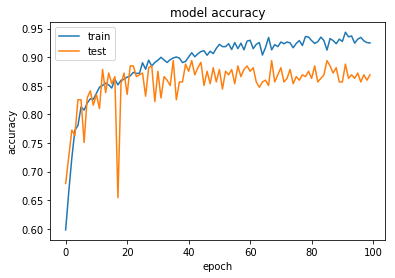

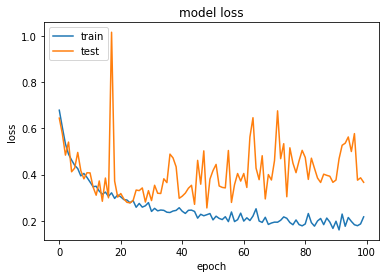

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
dd=model.predict(X_test_scale,batch_size=batch_size,verbose=1)

8424/8424 [==============================] - 196s 23ms/step


In [20]:
model_results = pd.DataFrame()

for i in range(len(test_id)):
    model_results = model_results.append({'id': test_id[i][0], 'is_iceberg' :dd[i][0]}, ignore_index=True)

model_results.to_csv("model_results.csv",index=False)

## Loaded Model from FS

In [21]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [25]:
dd2=loaded_model.predict(X_test_scale,batch_size=batch_size,verbose=1)

8424/8424 [==============================] - 31s 4ms/step


In [26]:
loaded_results = pd.DataFrame()
for i in range(len(test_id)):
    loaded_results = loaded_results.append({'id': test_id[i][0], 'is_iceberg' :dd2[i][0]}, ignore_index=True)

loaded_results.to_csv("loadedmodelresults.csv",index=False)